In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sessions.csv
/kaggle/input/test_users.csv
/kaggle/input/age_gender_bkts.csv
/kaggle/input/countries.csv
/kaggle/input/sample_submission.csv
/kaggle/input/sample_submission_NDF.csv
/kaggle/input/train_users_2.csv


# First lets do data wrangling
so before starting with any analysis or run algorithem, we need to clean , transform it to proper formate, deal with null values, and feature engineering
1. train_user file
2. sessions
3. countries
4. age_gender_bkts

In [2]:
#loading all the files and checking their shapes respectively
train_df = pd.read_csv('../input/train_users_2.csv',parse_dates=['date_account_created'])
test_df = pd.read_csv('../input/test_users.csv',parse_dates=['date_account_created'])
age_gender_df = pd.read_csv('../input/age_gender_bkts.csv')
countries_df = pd.read_csv('../input/countries.csv')
session_df = pd.read_csv('../input/sessions.csv')
train_df.shape,test_df.shape,age_gender_df.shape,countries_df.shape,session_df.shape

((213451, 16), (62096, 15), (420, 5), (10, 7), (10567737, 6))

In [3]:
train_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


# countries

In [4]:
countries_df.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [5]:
countries_df.shape

(10, 7)

# Age Gender

In [6]:
age_gender_df.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [7]:
age_gender_df.age_bucket.value_counts()

50-54    20
15-19    20
95-99    20
45-49    20
100+     20
25-29    20
80-84    20
35-39    20
30-34    20
90-94    20
65-69    20
55-59    20
60-64    20
10-14    20
0-4      20
40-44    20
75-79    20
70-74    20
85-89    20
5-9      20
20-24    20
Name: age_bucket, dtype: int64

In [8]:
#as all the age is in kind of buckets except 100+ one so lets convert that also into bucket.
age_gender_df['age_bucket'] = age_gender_df.age_bucket.apply(lambda x: '100-104' if x == '100+' else x)

In [9]:
# actually the age bins provides the categorical values but we can have numeric values representing continues 
#values
age_gender_df['mean_age'] = age_gender_df.age_bucket.apply(lambda x: (int(x.split('-')[0])
                                                                      +int(x.split('-')[1]))/2)

In [10]:
age_gender_df.head()

,age_bucket,country_destination,gender,population_in_thousands,year,mean_age
0,100-104,AU,male,1.0,2015.0,102.0
1,95-99,AU,male,9.0,2015.0,97.0
2,90-94,AU,male,47.0,2015.0,92.0
3,85-89,AU,male,118.0,2015.0,87.0
4,80-84,AU,male,199.0,2015.0,82.0


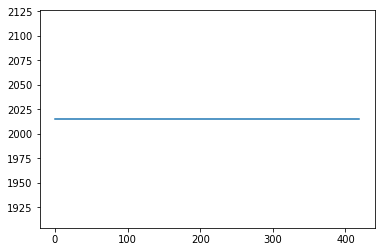

In [11]:
import seaborn as sns
#as it has same values across the data frame better to remove this column
age_gender_df.year.plot()
age_gender_df.drop(['year'],axis=1,inplace=True)

In [12]:
age_gender_df.head()

,age_bucket,country_destination,gender,population_in_thousands,mean_age
0,100-104,AU,male,1.0,102.0
1,95-99,AU,male,9.0,97.0
2,90-94,AU,male,47.0,92.0
3,85-89,AU,male,118.0,87.0
4,80-84,AU,male,199.0,82.0


## sessions

In [13]:
session_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [14]:
session_df.shape

(10567737, 6)

## Training Users

In [15]:
train_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [16]:
train_df.shape

(213451, 16)

In [17]:
(train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)

date_first_booking         0.583473
age                        0.412226
first_affiliate_tracked    0.028414
country_destination        0.000000
first_browser              0.000000
first_device_type          0.000000
signup_app                 0.000000
affiliate_provider         0.000000
affiliate_channel          0.000000
language                   0.000000
signup_flow                0.000000
signup_method              0.000000
gender                     0.000000
timestamp_first_active     0.000000
date_account_created       0.000000
id                         0.000000
dtype: float64

as age, date_first_booking are having almost 50 % missing values.

we could consider removing data_first_booking colum as we cant impute it's missing values with any of the methods like(mean, 90%, etc..) and data will be of first user booking as we are predicting for new user these feature doesn't make any sesne.

about age colum we try out possibilities of imputing with (avg, 90%) or we can treat as it is because it might give more insights.

For first affiliated method we can consider keeping null values as a unknow or other source.

In [18]:
#lets see value counts for each of the categorical columns to  see if any of the values hardcoded in some common formate
category_columns = list(train_df.columns[train_df.dtypes == np.object].values)
category_columns.remove('date_first_booking') #doesnt make any sense to  see how many unique dates are present
category_columns.remove('country_destination') #target column 
category_columns.remove('id') #because it's unique one
print(category_columns)

['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']


In [19]:
#lets print values counts for above columns
for a in category_columns:
    print(train_df[a].value_counts(),'value coutns',a)

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64 value coutns gender
basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64 value coutns signup_method
en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
th        24
el        24
id        22
hu        18
fi        14
is         5
ca         5
hr         2
Name: language, dtype: int64 value coutns language
direct           137727
sem-brand         26045
sem-non-brand     18844
other              8961
seo                8663
api                8167
content            3948
remarketing        1096
Name: affiliate_channel, dtype: int64 value coutns affiliate_channel
direct                 137426
google                  51693
other                   12549
craigslist               3471
bi

And we can see all values make sense

In [20]:
#handling Age column
train_df.loc[train_df.age>120,'age'] = np.nan
train_df.age.fillna(train_df.age.mean(),inplace=True)

## EDA on training users

## Stacked bar visualization 

The stacked bar chart gives us a collection of proportionately colored bars where each color represents a class (or the destination). Since there are more than 10 classes, I chose to forego the legend. The colors we are concerned with are dark blue (bottom bar) which corresponds to the NDF class and blue (second bottom bar) which corresponds to the US Class. As we have already seen, these two classes form the majority and therefore, will occupy most of the area of each bar. Each bar has been normalized with respect to its size.

What we will try to deduce is the proportion of the bar which belongs to the non booking class (dark blue). If this is large, it means that particular segment are unlikely to book an Airbnb. If small, it means they are more inclined to do so.

In [21]:
#actuvally stacked_bar is the concept to capture 

classes = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
def stacked_bar(feature):
    ctab = pd.crosstab([train_df[feature].fillna('Unknown')], train_df.country_destination, dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab[classes].plot(kind='bar', stacked=True, colormap='terrain', legend=False)
    
    

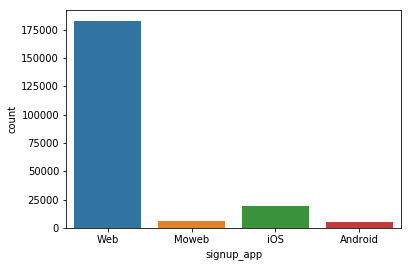

In [22]:
sns.countplot(data=train_df,x='signup_app')

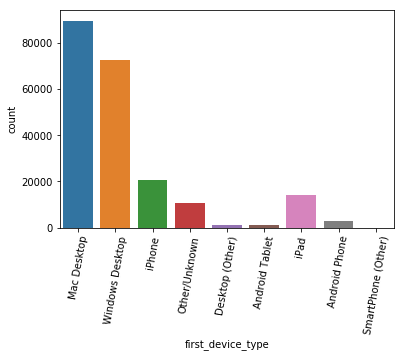

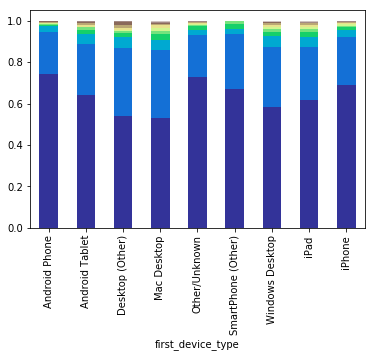

In [23]:
g = sns.countplot(data=train_df,x='first_device_type')
plt.xticks(rotation=80)
stacked_bar('first_device_type')

From above thing we were able first_device_type, signup_type : the web followed by ios people are making bookings and desktop (mac, windows) follwed by iphone users are most likely make booking.

the andriod users and unknown users are unlikely to make booking

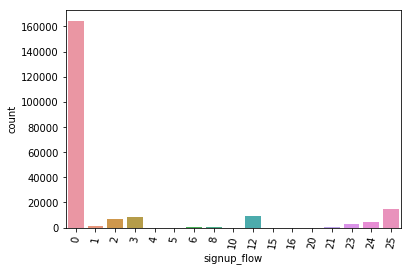

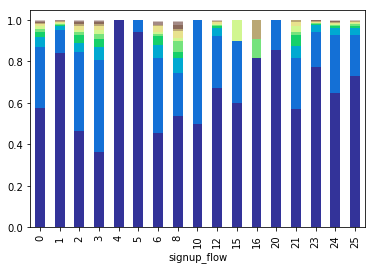

In [24]:
g = sns.countplot(data=train_df,x='signup_flow')
plt.xticks(rotation=80)
stacked_bar('signup_flow')

Poeple from 3, 2 and 6 are most likely to signup than from 4,5 pages

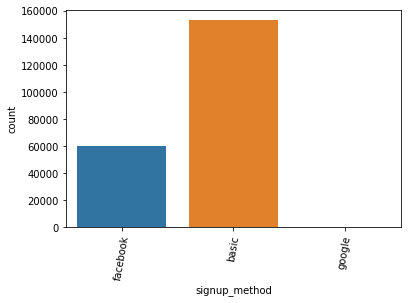

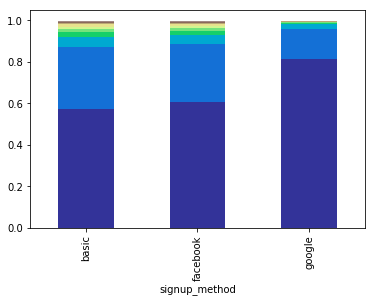

In [25]:
g = sns.countplot(data=train_df,x='signup_method')
plt.xticks(rotation=80)
stacked_bar('signup_method')

basic and facebook users are the most likely to make bookings

In [26]:
def set_age_group(x):
    if x < 40:
        return 'young'
    elif x >=40 and x<60:
        return 'middle'
    elif x>=60 and x <=125:
        return 'old'
    else:
        return 'unknown'

In [27]:
train_df['age_group'] = train_df['age'].apply(set_age_group)

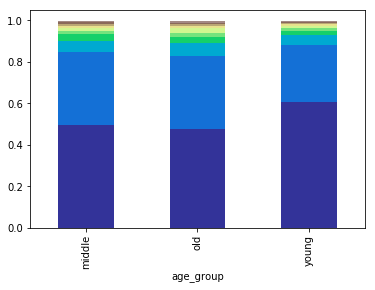

In [28]:
stacked_bar('age_group')

so divided the age group based on the age and plotted.

And people who signedup with unknown are not making any booking. Remaining groups are having same bookings

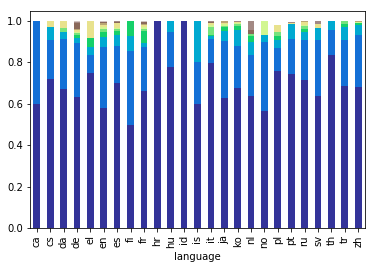

In [29]:
stacked_bar('language')

hungarian and indonesian language speaking people are making least bookings.

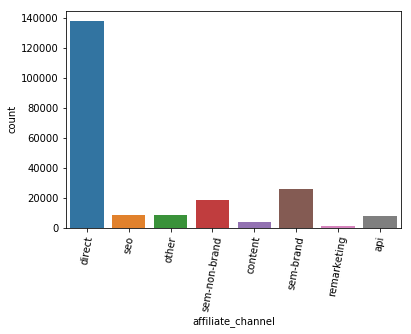

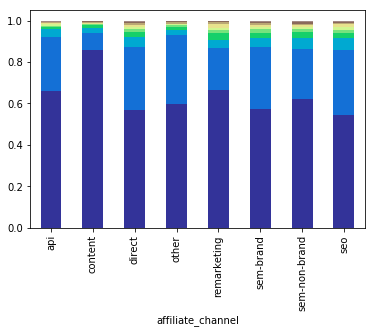

In [30]:
g = sns.countplot(data=train_df,x='affiliate_channel')
plt.xticks(rotation=80)
stacked_bar("affiliate_channel")

eventough the direct has lot of interactions with website compared to others, they both ended up making almost same bookings.

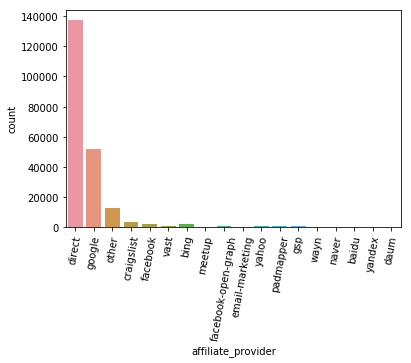

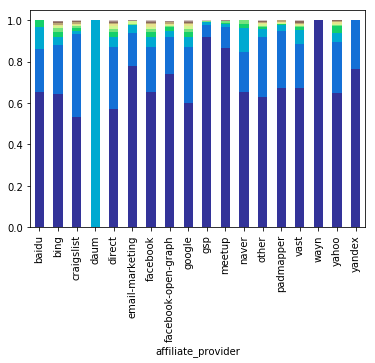

In [31]:
g = sns.countplot(data=train_df,x='affiliate_provider')
plt.xticks(rotation=80)
stacked_bar("affiliate_provider")

Google and direct are the most affiliate providers
and Daum has the most bookigns but wayn has the least

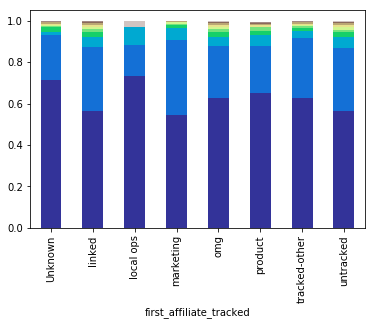

In [32]:
stacked_bar('first_affiliate_tracked')

fist affiliate through marketing are most likely to make booking and unknown and local ops are least bookings.

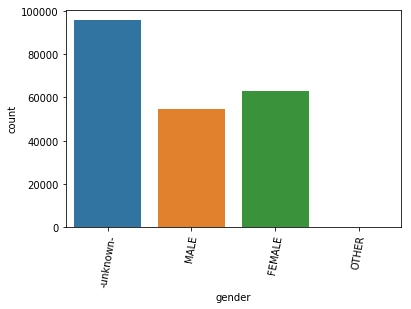

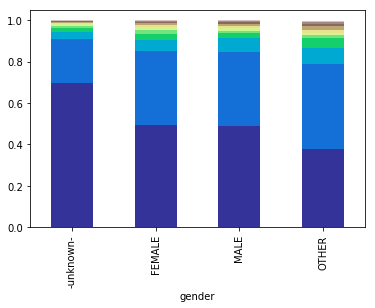

In [33]:
sns.countplot(train_df['gender'].fillna('Unknown'))
plt.xticks(rotation=80)
stacked_bar('gender')

most of the interactions are people who's gender is unknow, and followed by female's.

people who's gender marked didnt mark less likely to make bookings, and who marked as others most likely do bookings.

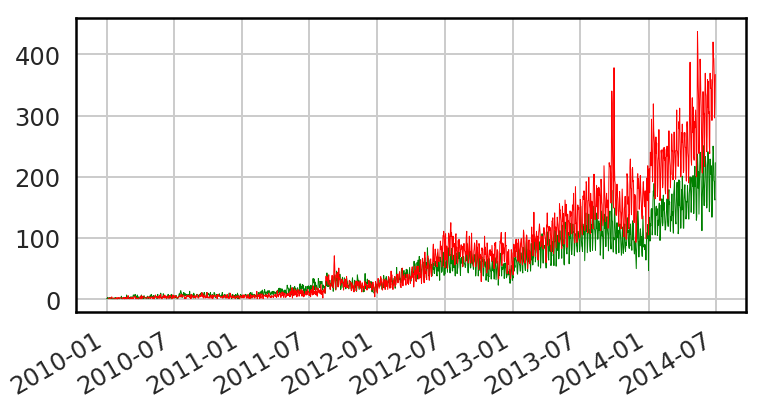

In [34]:

sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
plt.figure(figsize=(12,6))

train_df[train_df['country_destination'] != 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='green')
train_df[train_df['country_destination'] == 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='red')

## EDA on sessions statistics


In [35]:
session_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [36]:
session_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


<Figure size 864x432 with 0 Axes>

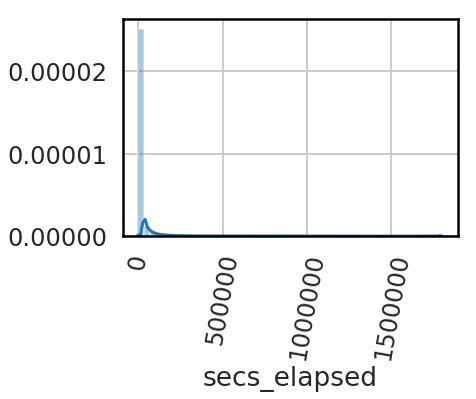

<Figure size 864x432 with 0 Axes>

In [37]:
sns.distplot(session_df[session_df['secs_elapsed'].notnull()]['secs_elapsed'])
plt.xticks(rotation=80)
plt.figure(figsize=(12,6))

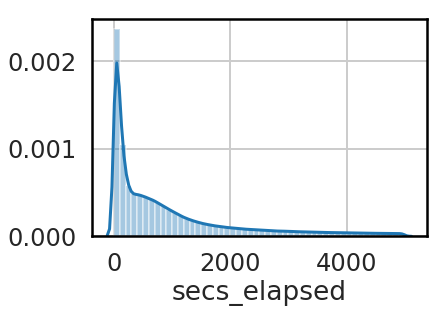

In [38]:
sns.distplot(session_df[(session_df['secs_elapsed'].notnull()) & (session_df['secs_elapsed'] < 5000)]['secs_elapsed'])

as we can see most of time user spend on the website is less than 2000

In [39]:
len(session_df[session_df['secs_elapsed'] < 1000])/len(session_df[session_df['secs_elapsed'].notnull()])

0.47335699453186275

Almost 47 % of sessions are under 1000 so we can say as the number of time spent on the website increase then number of users will decrease exponentially 

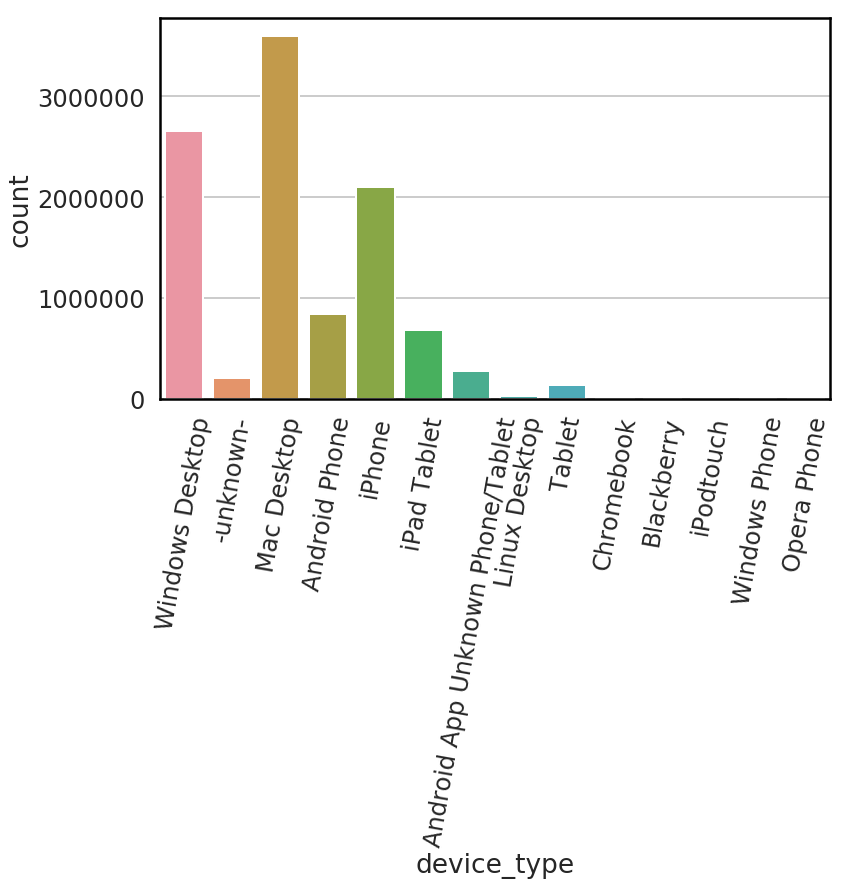

In [40]:
plt.figure(figsize=(12,7))
plt.xticks(rotation=80)
sns.countplot(x='device_type', data=session_df)

as we have concluded from EDA of training data most used devices are mac and windows desktops followed by iphone devices

## EDA on country

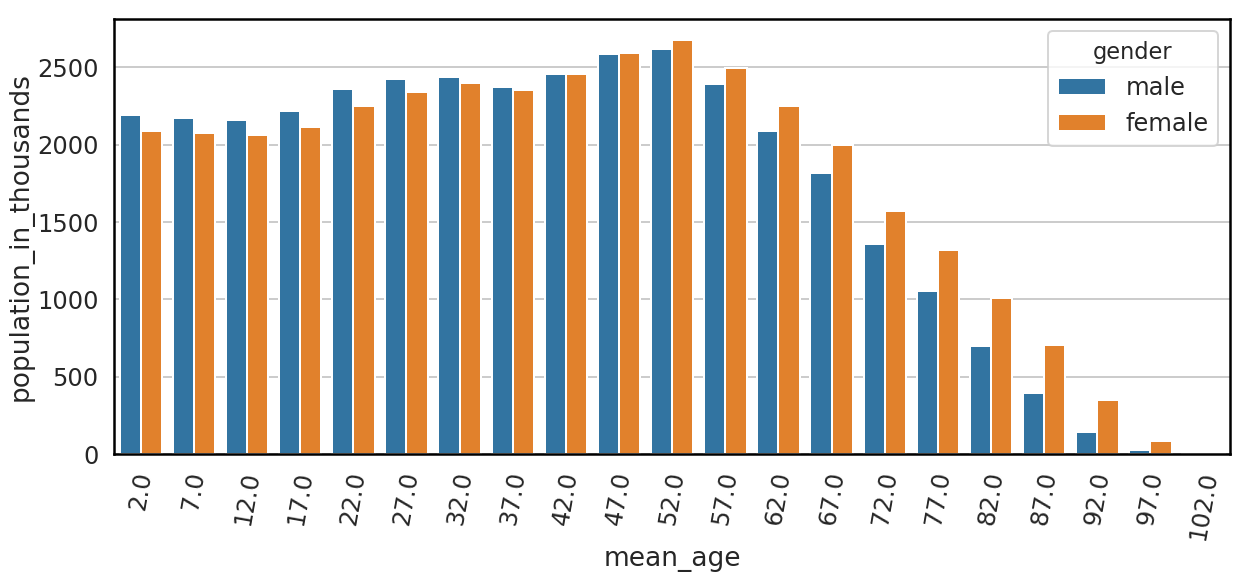

In [41]:
# we have figered out mean age so lets see the age distribution according to the bookings

plt.figure(figsize=(20,8))
plt.xticks(rotation=80)
sns.barplot(x='mean_age', y='population_in_thousands', hue='gender', data=age_gender_df, ci=None)

we see 47 and 52 are the most aged people, and old people are very less likely to interactions.

And as the age progress women are the most likely to travel than men and in the early age man are most likely to book

In [42]:
age_gender_df.head()

,age_bucket,country_destination,gender,population_in_thousands,mean_age
0,100-104,AU,male,1.0,102.0
1,95-99,AU,male,9.0,97.0
2,90-94,AU,male,47.0,92.0
3,85-89,AU,male,118.0,87.0
4,80-84,AU,male,199.0,82.0
